This code only works after installing the webdriver and does not work on Colab! Only on local platform.

In [ ]:
# import libraries
import pandas as pd
import requests

import seaborn as sns
import matplotlib.pyplot as plt

from selenium import webdriver

# An explicit wait is a code you define to wait for a certain condition to occur before proceeding further in the code
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
options = webdriver.ChromeOptions()
options.headless = False
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()),options=options)
driver.maximize_window()
driver.implicitly_wait(10)




In [ ]:
# getting a language
languages = ['az', 'en', 'ru']
# go to site
driver.get(f"https://opendata.az/{languages[1]}")

In [ ]:
# keywords
keywords = []
keyword_driver = WebDriverWait(driver, 20).until(
EC.visibility_of_element_located((By.XPATH, '//*[@id="root"]/div[2]/div[2]/div/div/section[1]/div/div/div/div/ul/div/div')))
for i in keyword_driver.find_elements(By.TAG_NAME, 'li'):
    keywords.append((i.get_attribute("innerText")))

print('It is keyword list')
print(keywords)

It is keyword list
['plant', 'migration', 'passenger', 'pupil', 'teacher', 'school', 'water resources', 'atmosphere', 'theater', 'statistics', 'district', 'registration', 'geodesy and cartography', 'places and locations', 'places', 'service', 'highways', 'mountains', 'national parks', 'lakes']

In [ ]:
# You can take one of the keywords and submit it for processing. I took the word "school".

input_btn = '//*[@id="root"]/div[2]/div[2]/div/div/section[1]/div/div/div/div/div[2]/div[1]/input'
# Passing the selected word to the search bar

input_driver = WebDriverWait(driver, 20).until(
EC.visibility_of_element_located((By.XPATH, f'{input_btn}')))

input_driver.send_keys("school")
button = driver.find_element(By.XPATH, "//li[./text()='school']")

button.click()



In [ ]:
# If the data is on multiple pages, then we must iteratively go through the pages and collect their titles and links to them (try block).

# If the data is only on one page, then we take all the titles and links to this data from this page (except block).

# All titles and references are in the dict.
dicts={}
data_link_container = '//*[@id="root"]/div[2]/div[2]/div/section/div/div/div/div/div[3]/div/div[2]'
try:
    page_num = WebDriverWait(driver, 20).until(EC.visibility_of_element_located(
        (By.XPATH, f'{data_link_container}/ul'))).get_attribute(
        'innerText')[-1]
    for i in range(1, int(page_num) + 1):
        element = WebDriverWait(driver, 20).until(EC.visibility_of_element_located(
            (By.XPATH, f'{data_link_container}/ul/li[4]/button')))

        ex_driver = WebDriverWait(driver, 20).until(EC.visibility_of_element_located(
            (By.XPATH, f'{data_link_container}')))

        for v in range(len(ex_driver.find_elements(By.CSS_SELECTOR, 'a'))):
            dicts[ex_driver.find_elements(By.TAG_NAME, 'h3')[v].get_attribute("innerText")] = \
                ex_driver.find_elements(By.CSS_SELECTOR, 'a')[v].get_attribute("href")
        driver.execute_script("arguments[0].scrollIntoView(true);", element)
        driver.execute_script("arguments[0].click();", element)
except:
    ex_driver = WebDriverWait(driver, 20).until(
        EC.visibility_of_element_located((By.XPATH, f'{data_link_container}/div')))
    for v in range(len(ex_driver.find_elements(By.CSS_SELECTOR, 'a'))):
        dicts[ex_driver.find_elements(By.TAG_NAME, 'h3')[v].get_attribute("innerText")] = \
            ex_driver.find_elements(By.CSS_SELECTOR, 'a')[v].get_attribute("href")
print('It is titles of datasets')
print(list(dicts.keys()))

It is titles of datasets
['Information about full-time general education institutions']

In [ ]:
# After that, you can select any title and the script will receive this data as a json file and then create a DataFrame object from it.
driver.get(dicts['Information about full-time general education institutions'])
link=driver.find_element(By.XPATH, '//*[@id="root"]/div[2]/div[2]/div/section/div/div/div/div[3]/div[1]/div[1]/div[2]')
data = requests.get(str(link.text)).json()['statDtos']
df = pd.DataFrame.from_dict(data)

In [ ]:
# The structure of almost all data is the same and they contain numeric values except for the "indicator" column.

# Due to the fact that the meanings of this column are in Azerbaijani, we must translate them.

for i in range(len(df['indicator'].unique())):
    phrase = df['indicator'].unique()[i]
    driver.get(f"https://translate.google.com/?sl=az&tl=en&text={phrase}&op=translate")
    condition = EC.presence_of_element_located(
    (By.XPATH,'//*[@id="yDmH0d"]/c-wiz/div/div[2]/c-wiz/div[2]/c-wiz/div[1]/div[2]/div[3]/c-wiz[2]/div/div[8]/div/div[1]/span[1]/span/span'))
    element = WebDriverWait(driver, 10).until(condition)
    translation = element.text
    df['indicator'].replace(df['indicator'].unique()[i], translation, inplace=True)
# dataframe[column].apply() is very slow

In [ ]:
print('It is unique values of indicator column')
print(df['indicator'].unique())

It is unique values of indicator column
['Number of general educational institutions in correspondence (evening)'
 'Number of students in the general education institutions in absentia (evening)'
 'Number of teachers in General educational institutions in correspondence (evening)']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

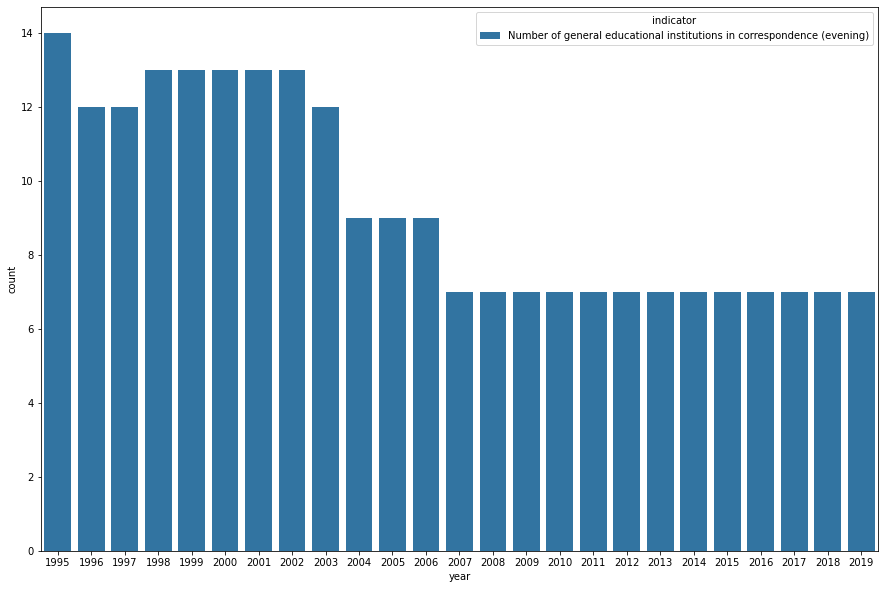

In [ ]:
# After getting the unique values of the "indicator" column, we can visualize them.

plt.figure(figsize=(15, 10))
sns.barplot(data=df[df['indicator']=='Number of general educational institutions in correspondence (evening)'], x="year", y="count", hue='indicator')

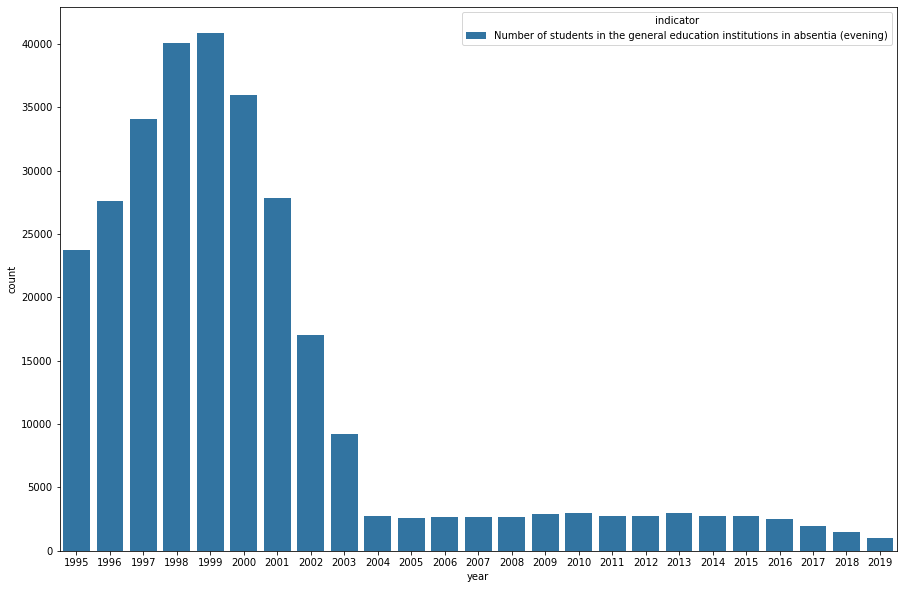

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(data=df[df['indicator']=='Number of students in the general education institutions in absentia (evening)'], x="year", y="count", hue='indicator')

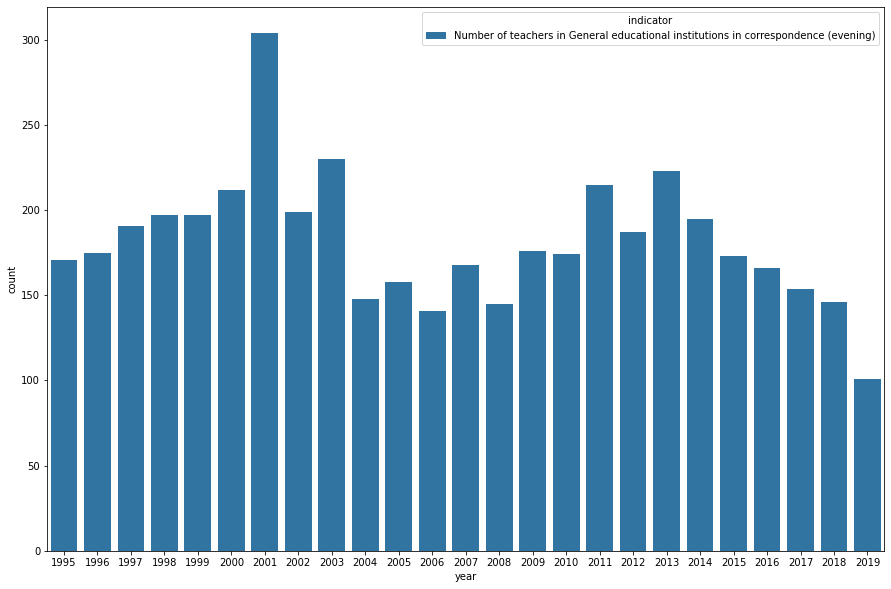

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(data=df[df['indicator']=='Number of teachers in General educational institutions in correspondence (evening)'], x="year", y="count", hue='indicator')


Our data reflects the number of distance learning institutions in the evening shift, the number of their students and teachers. Data collected from 1995 to 2019.
The amount of data is only 75 and visualization can be used to better understand the data. If we had a huge amount of data, we could use statistical analysis, such as descriptive statistics. The histogram will best show the trend of changing parameter values.
It is built to analyze changes in the number of educational institutions, the number of their students and teachers over the years. From this histogram it can be seen that from the beginning of data collection, the number of educational institutions from 1995 to 2007 decreased and remained stable. In 1995, the number of educational institutions was 14 and gradually decreased to 7 in 2007.
The number of students has increased since 1995 and reached its peak in 2000. In 2000, the number of students was 35979 students. After 2000, the number of students began to fall rapidly until 2004, after which it remained relatively stable until the end of the year of data collection.
From 2000 to 2004, in just 4 years, the number of students decreased to 2774, i.e. by 93%. If we had additional data, then probably some of them would have a high correlation with this parameter. It could be the adoption of some kind of law or a drop in interest in distance learning.
This may also be affected by a decrease in the number of educational institutions, but the causal relationship may be reversed. Most likely, the number of educational institutions has decreased due to the loss of interest in distance learning and a decrease in the number of students.
In 2019, the number of students was a historical minimum - 1033 students. The law of changing the number of teachers is slightly different from the other parameters and has two periods of its development. Since 1995, the number of teachers
increases and reaches 304 teachers in 2001. Starting from this period, the number of teachers begins to fall, although sometimes it increases. Until 2006, the number of teachers decreases by 54% compared to 2001 and amounts to 141 teachers. This drop can be explained by a decrease in the number of educational institutions and the number of students.
But since 2006, in general, we have seen an increase in teachers, which reaches its second peak in 2013 and reaches 223 teachers. After that, it begins to decrease and in 2019 it is 101 teachers.
After the first decline, the second period of increase in the number of teachers is difficult to explain, but this may be due to reforms in the education system.